In [13]:
!pip install tensorflow opencv-python matplotlib

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
DATA_DIR = "/content/drive/MyDrive/EN3150/data/RealWaste"

In [16]:
import tensorflow as tf
import numpy as np

# Paths and constants
DATA_DIR = "/content/drive/MyDrive/EN3150/data/RealWaste"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123

# 70% train, 15% val, 15% test
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.3,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.3,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Split val/test half-half (15% each)
val_batches = int(0.5 * tf.data.experimental.cardinality(val_test_ds).numpy())
val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

Found 4752 files belonging to 9 classes.
Using 3327 files for training.
Found 4752 files belonging to 9 classes.
Using 1425 files for validation.


In [17]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [10]:
len(train_ds)

104

In [11]:
len(test_ds)

23

In [12]:
len(val_ds)

22

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

num_classes = 9
dropout_rate = 0.5  # Dropout rate (d)
input_shape = (224, 224, 3)

model = Sequential([
    # First Convolutional Layer (x1 filters, m1×m1 kernel)
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2,2)),

    # Second Convolutional Layer (x2 filters, m2×m2 kernel)
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    # Flatten the feature maps
    Flatten(),

    # Fully Connected Layer (x3 units)
    Dense(128, activation='relu'),

    # Dropout Layer (rate d)
    Dropout(dropout_rate),

    # Output Layer (K units for K classes)
    Dense(num_classes, activation='softmax')
])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,908,553 (91.20 MB)

 Trainable params: 23,908,553 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
logdir='logs'

In [28]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [31]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)


model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

hist = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[tensorboard_callback])

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 1245s 12s/step - accuracy: 0.2679 - loss: 2.0030 - val_accuracy: 0.3949 - val_loss: 1.7697
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 63s 614ms/step - accuracy: 0.4314 - loss: 1.6337 - val_accuracy: 0.4716 - val_loss: 1.5079
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 35s 341ms/step - accuracy: 0.4991 - loss: 1.3938 - val_accuracy: 0.5483 - val_loss: 1.2884
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 30s 287ms/step - accuracy: 0.5979 - loss: 1.1485 - val_accuracy: 0.5696 - val_loss: 1.1864
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 26s 249ms/step - accuracy: 0.6661 - loss: 0.9200 - val_accuracy: 0.5724 - val_loss: 1.3034
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 24s 231ms/step - accuracy: 0.7528 - loss: 0.7065 - val_accuracy: 0.5455 - val_loss: 1.3431
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 24s 232ms/step - accuracy: 0.7831 - loss: 0.5993 - val_accuracy: 0.5668 - val_loss: 1.3600
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.8462 - loss: 0

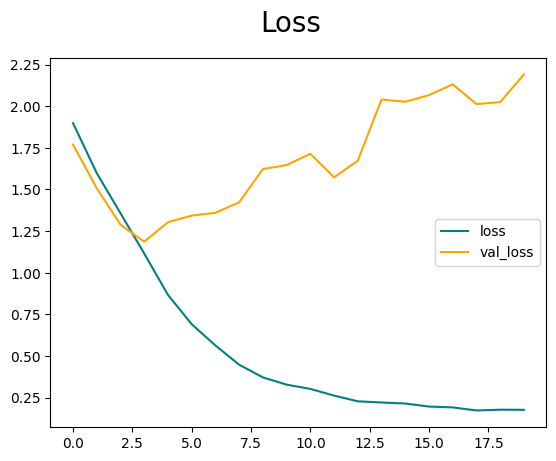

In [34]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="center right")
plt.show()